In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import caffe
import score
import tools
import time

In [2]:
def fast_hist(a, b, n):
    k = (a >= 0) & (a < n) # a boolean index array 
    # Select only positive samples less than # of classes (i.e. values 0 - 10 for 11-class fcn)
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n**2).reshape(n, n)

def compute_hist(net, save_dir, dataset, layer='score', gt='label'):
    # N.B. channels refers to num_output pages for FCN
    n_cl = net.blobs[layer].channels
    if save_dir:    
    	os.mkdir(save_dir)
    hist = np.zeros((n_cl, n_cl))
    loss = 0
    for idx in dataset:
        net.forward()
        hist += fast_hist(net.blobs[gt].data[0, 0].flatten(),
                                net.blobs[layer].data[0].argmax(0).flatten(),
                                n_cl)

        if save_dir:
            im = Image.fromarray(net.blobs[layer].data[0].argmax(0).astype(np.uint8), mode='P')
            im.save(os.path.join(save_dir, idx + '.png'))
        # compute the loss as well
        loss += net.blobs['loss'].data.flat[0]
    return hist, loss / len(dataset)

def seg_tests(solver, save_format, dataset, layer='score', gt='label'):
    print '>>>', datetime.now(), 'Begin seg tests'
    solver.test_nets[0].share_with(solver.net)
    do_seg_tests(solver.test_nets[0], solver.iter, save_format, dataset, layer, gt)

def do_seg_tests(net, iter, save_format, dataset, layer='score', gt='label'):
    n_cl = net.blobs[layer].channels
    if save_format:
        save_format = save_format.format(iter)
    hist, loss = compute_hist(net, save_format, dataset, layer, gt)
    # mean loss
    print '>>>', datetime.now(), 'Iteration', iter, 'loss', loss
    # overall accuracy
    acc = np.diag(hist).sum() / hist.sum()
    print '>>>', datetime.now(), 'Iteration', iter, 'overall accuracy', acc
    # per-class accuracy
    acc = np.diag(hist) / hist.sum(1)
    print '>>>', datetime.now(), 'Iteration', iter, 'mean accuracy', np.nanmean(acc)
    # per-class IU
    iu = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
    print '>>>', datetime.now(), 'Iteration', iter, 'mean IU', np.nanmean(iu)
    freq = hist.sum(1) / hist.sum()
    print '>>>', datetime.now(), 'Iteration', iter, 'fwavacc', \
            (freq[freq > 0] * iu[freq > 0]).sum()
    return hist

In [40]:
caffe.set_device(0)
caffe.set_mode_cpu()

caffe_root = '/home/cv/hdl/caffe'
part = 'head'
models = '{}/models'.format(caffe_root)

# load image, switch to BGR, subtract mean, and make dims C x H x W for Caffe
im = Image.open('/home/cv/grayson/shelby_small.jpg')
in_ = np.array(im, dtype=np.float32)
in_ = in_[:,:,::-1]
in_ -= np.array((104.00698793,116.66876762,122.67891434))
in_ = in_.transpose((2,0,1))

# load net
# net = caffe.Net('model/deploy.prototxt',
#                 '{}/pascalpart-fcn32s/person/head/old_snapshots/train_iter_176000.caffemodel'.format(models), 
#                 caffe.TEST)
net = caffe.Net('model/deploy.prototxt',
                'snapshot/train_iter_80000.caffemodel'.format(models), 
                caffe.TEST)

# shape for input (data blob is N x C x H x W), set data
net.blobs['data'].reshape(1, *in_.shape)
net.blobs['data'].data[...] = in_

# must do forward pass or else blobs and deconv params will be all zeroes
net.forward()  

{'loss': array([[[[  9.95092869e-01,   9.96280730e-01,   9.97169197e-01, ...,
             9.99343455e-01,   9.99278843e-01,   9.99208510e-01],
          [  9.96129394e-01,   9.97083485e-01,   9.97792721e-01, ...,
             9.99553621e-01,   9.99507308e-01,   9.99456465e-01],
          [  9.96939063e-01,   9.97706890e-01,   9.98275042e-01, ...,
             9.99696612e-01,   9.99663115e-01,   9.99626398e-01],
          ..., 
          [  9.97877121e-01,   9.98381019e-01,   9.98760223e-01, ...,
             9.92164135e-01,   9.92051721e-01,   9.91936207e-01],
          [  9.97471094e-01,   9.98054147e-01,   9.98497009e-01, ...,
             9.91981149e-01,   9.91844356e-01,   9.91704464e-01],
          [  9.96987283e-01,   9.97662425e-01,   9.98177409e-01, ...,
             9.91791368e-01,   9.91630018e-01,   9.91463721e-01]],
 
         [[  3.35818529e-03,   2.65010446e-03,   2.09068949e-03, ...,
             4.02257487e-04,   4.38195333e-04,   4.77340742e-04],
          [  2.723972

In [41]:
# just the loss
net.blobs['loss'].data.flat[0]

0.99509287

In [42]:
# solver = caffe.SGDSolver('model/solver.prototxt')
# solver.test_nets[0].share_with(solver.net)
# val = np.loadtxt('{}/data/pascal/VOC/VOC2010/ImageSets/person/{}_val.txt'.format(caffe_root, part), dtype=str)

# hist, loss = do_seg_tests(solver.test_nets[0], solver.iter, False, val, 'score', 'label')

# hist += fast_hist(net.blobs['label'].data[0, 0].flatten(),
#                                 net.blobs['score'].data[0].argmax(0).flatten(),
#                                 11)

In [43]:
# plt.figure()
# plt.imshow(hist)

In [44]:
# print np.shape(net.blobs['label'].data[0,0])

In [45]:
# print np.shape(net.blobs['score'].data[0].argmax(0))
# print np.unique(net.blobs['score'].data[0].argmax(0))

In [46]:
#solver = caffe.SGDSolver('solver.prototxt')
#val = np.loadtxt('/home/cv/hdl/caffe/data/pascal/VOC/VOC2010/ImageSets/person/head_val.txt', dtype=str)

In [47]:
#hist, loss = score.compute_hist(solver.test_nets[0], 'segmentation_results', val, layer='score', gt='label' )

In [48]:
net.blobs['score'].channels

11

In [49]:
# blobs
# [(k, v.data.shape) for k, v in net.blobs.items()]

In [50]:
# parameters
# [(k, v[0].data.shape) for k, v in net.params.items()]

In [51]:
# conv layer weights (edge_detectors)
# print net.params['fc6'][0].data

In [52]:
# deconv layer weights
# print net.params['conv1_1'][0].data

In [53]:
# data blob
# print net.blobs['data'].data

In [54]:
# conv1_1 blob
# print net.blobs['conv1_1'].data

In [55]:
# pool1 blob
# print net.blobs['pool1'].data

In [56]:
# upscore blob
# print net.blobs['upscore'].data.shape
# print net.blobs['upscore'].data

(11, 500, 650)
Image size: (500, 650)
Detected object classes: [0 1]


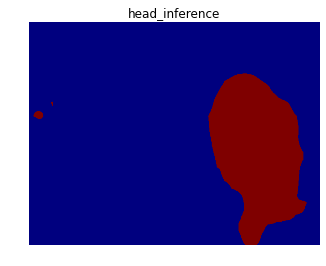

In [57]:
higher_level_filter = net.params['fc7'][0].data         # weights
# Recall: blob dimensions are N x C x H x W
print net.blobs['score'].data[0].shape
out = net.blobs['score'].data[0].argmax(axis=0)
fig = plt.figure()
plt.axis('off')
plt.title('head_inference')
imgplot = plt.imshow(out)
print 'Image size:', out.shape
print 'Detected object classes:', np.unique(out)

In [39]:
fig.savefig('torso_inference.png')